In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import awkward as ak
import correctionlib as cl
from coffea.lookup_tools import extractor
import uproot
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.colors as colors
import correctionlib.schemav2 as cs
import matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
import os
#matplotlib.use('pgf')
#from matplotlib.backends.backend_pgf import FigureCanvasPgf
#matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


In [2]:
def name_parser(name: str) -> dict:
    low_bin_end = name.find('to')
    high_bin_end = name.find('_', low_bin_end)
    out_dict = {
        "comp": name[3],
        "type": ''.join([the_char for the_char in name[high_bin_end:] if the_char.isalpha()]).lower(),
        "low_eta_bin": float(name[5:low_bin_end].replace('p', '.')),
        "high_eta_bin": float(name[low_bin_end+2:high_bin_end].replace('p', '.')),
        'full_reg_str': name[:-2]
    }
    return out_dict

In [3]:
def get_ip_correction_func(h_data, h_mc):
    bins = h_mc.axis().edges()
    bin_centers = ((bins[1:] + bins[:-1])/2)
    mc_vals = h_mc.values()
    data_vals = h_data.values()
    mc_cdf = gaussian_filter1d(np.cumsum(mc_vals)/np.sum(mc_vals), sigma=1)
    data_cdf = gaussian_filter1d(
        np.cumsum(data_vals)/np.sum(data_vals), sigma=1)
    #def clip(arr): return arr[:30]
    def make_quantile_mapping(ip_val,
                              ip_bins,
                              mc_cdf,
                              data_cdf):
        # Find the bin that contains ip_val
        # The reason for -1 is that the func. chooses right bin if val is located between two bins.
        idx = np.searchsorted(ip_bins, ip_val, side="left")-1
        bin_centers = ((ip_bins[1:] + ip_bins[:-1])/2)
        # Get correspondent mc cdf value
        # I want to approximate the function using central values of the two bins neighboring to the one containing val.
        if idx > 0 and idx < (mc_cdf.shape[0] - 1):
            # calculate local slope the mc cdf
            k_cdf2ip = (mc_cdf[idx+1] - mc_cdf[idx-1]) / \
                (bin_centers[idx+1]-bin_centers[idx-1])
            # Calculate mc cdf value corresponding to the ip_mc_val using linear approximation
            mc_cdf_val = mc_cdf[idx-1] + k_cdf2ip*(ip_val-bin_centers[idx-1])
            mc_formula_str = f'{mc_cdf[idx-1]} + {k_cdf2ip}*(x-({bin_centers[idx-1]}))'
        elif idx==0:
            mc_cdf_val = mc_cdf[idx]
            mc_formula_str = str(mc_cdf[idx])
        else:
            mc_cdf_val = mc_cdf[-1]
            mc_formula_str = str(mc_cdf[idx])
        # Now find bin of data_cdf that has the same value as mc_cdf_val
        idy = np.searchsorted(data_cdf, mc_cdf_val, side="left")
        if idy > 0 and idy < (data_cdf.shape[0]-1):
            k_ip2cdf = (bin_centers[idy+1] - bin_centers[idy-1]
                        )/(data_cdf[idy+1] - data_cdf[idy-1])
            ip_val_corr = bin_centers[idy-1] + \
                k_ip2cdf*(mc_cdf_val - data_cdf[idy-1])
            full_formula = f'{bin_centers[idy-1]} + {k_ip2cdf}*({mc_formula_str} - {data_cdf[idy-1]})'
        elif idy == 0:
            ip_val_corr = bin_centers[idy]
            full_formula = str(ip_val_corr)
        else: 
            ip_val_corr = bin_centers[-1]
            full_formula = str(ip_val_corr)
        return full_formula
    import functools
    formula_list = list(map(functools.partial(make_quantile_mapping,
                                              ip_bins=bins,
                                              mc_cdf=mc_cdf,
                                              data_cdf=data_cdf), bin_centers))
    return formula_list, bins


In [4]:
era_list =['Run3_2022', 'Run3_2022EE', 'Run3_2023','Run3_2023BPix']
dataset_list = ['mm','ee']
path =os.getcwd()+'/data/{era}/ip_corrections_{dataset}.root'
for era in era_list:
    corr_list = []
    for dataset in dataset_list:
        the_path = path.format(era=era, dataset=dataset)
        the_input = uproot.open(f"{path}")
        print(the_input.keys())
        print(f'Calculating correction for:{path}')
        h_list =[]
        for the_name, the_hist in the_input.items():
            h_props = name_parser(the_name) 
            h_props['hist'] = the_hist
            h_list.append(h_props)
        search_hist = lambda h_list, field, val: [h for h in h_list if h[field]==val]

        eta_bin_edges = np.unique([h[bin]
                                for h in h_list 
                                for bin in['low_eta_bin','high_eta_bin']])
        low_eta_edges =  np.unique([h['low_eta_bin'] for h in h_list]) 
        components = ['x','y','z']

        corr_binned_by_eta = []
        for the_eta_bin in low_eta_edges:
            single_eta_bin = []
            for the_comp in components:
                hists = search_hist(
                    search_hist(
                        h_list,'comp',the_comp),
                    'low_eta_bin',the_eta_bin)
                h_mc    = search_hist(hists, 'type', 'mc')[0]
                h_data  = search_hist(hists, 'type', 'data')[0]
                low_eta = h_mc['low_eta_bin']
                high_eta = h_mc['high_eta_bin']
                print(f'Performin quantile mapping for eta in [{low_eta} {high_eta}], component: {the_comp}')
                formula_strings, ip_bins = get_ip_correction_func(h_data['hist'], h_mc['hist'])
                
                cs_formula_list = []
                for the_formula in formula_strings: 
                    cs_formula_list.append(
                        cs.Formula(
                        nodetype="formula",
                        variables=["ip"],
                        parser="TFormula",
                        expression=the_formula,
                            ))
                single_eta_bin.append(
                    cs.CategoryItem(
                        key=the_comp,
                        value=cs.Binning(
                            nodetype="binning",
                            input="ip",
                            edges=ip_bins,
                            content=cs_formula_list,
                            flow="error"
                        )))
            corr_binned_by_eta.append(
                cs.Category(
                    nodetype="category",
                    input="ip_component",
                    content=single_eta_bin,
                )
            )
        corr_list.append(
            cs.Correction(
                name=f"ip_correction_{dataset}",
                description=f"Impact parameter correction for {era} era, using {dataset} dataset",
                version=2,
                inputs=[
                    cs.Variable(name="ip", type="real",description="Impact parameter component"),
                    cs.Variable(name="ip_component", type="string", description="x,y, or z"),
                    cs.Variable(name="eta", type="real", description="Absolute value of peudorapidity of the object for which IP was calculated"),
                ],
                output=cs.Variable(name="corrected_ip", type="real", description="Corrected Impact parameter component"),
                data=cs.Binning(
                    nodetype="binning",
                    input="eta",
                    edges=eta_bin_edges.tolist(),
                    content=corr_binned_by_eta,
                    flow='error',
                    ),
                )
        )
    cset = cs.CorrectionSet(
        schema_version=2,
        description="Impact paramter correction calculated via quantile mapping",
        corrections=corr_list
    )
    with open(os.getcwd() + f"/output/ip_correction_{era}.json", "w+") as fout:
            fout.write(cset.model_dump_json(exclude_unset=True))

['ip_x_0p0to0p9_MC;1', 'ip_x_0p0to0p9_data;1', 'ip_x_0p9to1p2_MC;1', 'ip_x_0p9to1p2_data;1', 'ip_x_1p2to2p1_MC;1', 'ip_x_1p2to2p1_data;1', 'ip_x_2p1to2p4_MC;1', 'ip_x_2p1to2p4_data;1', 'ip_y_0p0to0p9_MC;1', 'ip_y_0p0to0p9_data;1', 'ip_y_0p9to1p2_MC;1', 'ip_y_0p9to1p2_data;1', 'ip_y_1p2to2p1_MC;1', 'ip_y_1p2to2p1_data;1', 'ip_y_2p1to2p4_MC;1', 'ip_y_2p1to2p4_data;1', 'ip_z_0p0to0p9_MC;1', 'ip_z_0p0to0p9_data;1', 'ip_z_0p9to1p2_MC;1', 'ip_z_0p9to1p2_data;1', 'ip_z_1p2to2p1_MC;1', 'ip_z_1p2to2p1_data;1', 'ip_z_2p1to2p4_MC;1', 'ip_z_2p1to2p4_data;1']
Calculating correction for:/home/stzakhar/Downloads/ip_corrections/Run3_2022/ip_corrections_mm.root
Performin quantile mapping for eta in [0.0 0.9], component: x
Performin quantile mapping for eta in [0.0 0.9], component: y
Performin quantile mapping for eta in [0.0 0.9], component: z
Performin quantile mapping for eta in [0.9 1.2], component: x
Performin quantile mapping for eta in [0.9 1.2], component: y
Performin quantile mapping for eta in

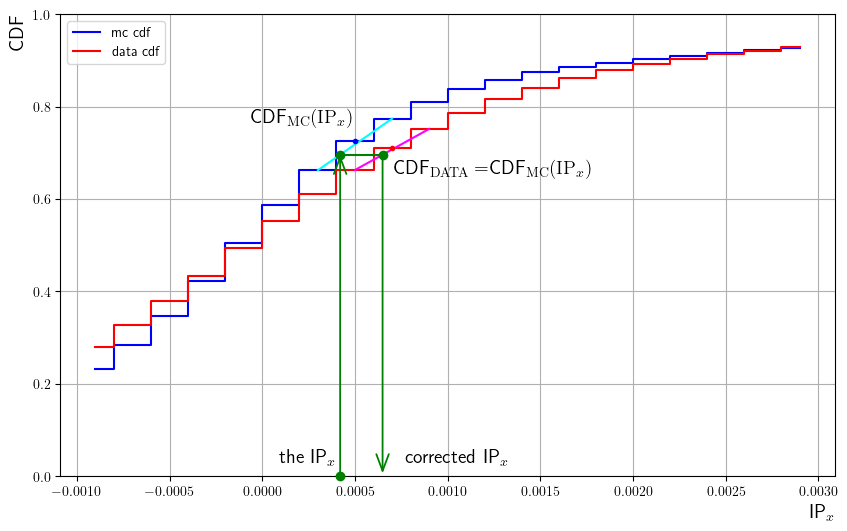

In [5]:
path = '/home/stzakhar/Downloads/ip_corrections/Run3_2022/ip_corrections_mm.root'
the_era = 'Run3_2022'
the_dataset = 'mm'
the_input = uproot.open(f"{path}")
name_parser(the_input.keys()[3])

h_mc = the_input['ip_x_2p1to2p4_MC;1']
h_data = the_input['ip_x_2p1to2p4_data;1']

def get_ip_correction_func(h_data, h_mc,plot_qm=False):
    bins = h_mc.axis().edges()
    bin_centers = ((bins[1:] + bins[:-1])/2)
    mc_vals = h_mc.values()
    data_vals = h_data.values()
    mc_cdf = gaussian_filter1d(np.cumsum(mc_vals)/np.sum(mc_vals), sigma=1)
    data_cdf = gaussian_filter1d(
        np.cumsum(data_vals)/np.sum(data_vals), sigma=1)
    if plot_qm:
        def clip(arr): return arr[145:165]
    else:
        def clip(arr): return arr[:]
    def make_quantile_mapping(ip_val,
                              ip_bins,
                              mc_cdf,
                              data_cdf):
        # Find the bin that contains ip_val
        # The reason for -1 is that the func. chooses right bin if val is located between two bins.
        idx = np.searchsorted(ip_bins, ip_val, side="left")-1
        bin_centers = ((ip_bins[1:] + ip_bins[:-1])/2)
        # Get correspondent mc cdf value
        # I want to approximate the function using central values of the two bins neighboring to the one containing val.
        if idx > 0 and idx < (mc_cdf.shape[0] - 1):
            # calculate local slope the mc cdf
            k_cdf2ip = (mc_cdf[idx+1] - mc_cdf[idx-1]) / \
                (bin_centers[idx+1]-bin_centers[idx-1])
            # Calculate mc cdf value corresponding to the ip_mc_val using linear approximation
            mc_cdf_val = mc_cdf[idx-1] + k_cdf2ip*(ip_val-bin_centers[idx-1])
            mc_formula_str = f'{mc_cdf[idx-1]} + {k_cdf2ip}*(x-({bin_centers[idx-1]}))'
        elif idx==0:
            mc_cdf_val = mc_cdf[idx]
            mc_formula_str = str(mc_cdf[idx])
        else:
            mc_cdf_val = mc_cdf[-1]
            mc_formula_str = str(mc_cdf[idx])
        # Now find bin of data_cdf that has the same value as mc_cdf_val
        idy = np.searchsorted(data_cdf, mc_cdf_val, side="left")
        if idy > 0 and idy < (data_cdf.shape[0]-1):
            k_ip2cdf = (bin_centers[idy+1] - bin_centers[idy-1]
                        )/(data_cdf[idy+1] - data_cdf[idy-1])
            ip_val_corr = bin_centers[idy-1] + \
                k_ip2cdf*(mc_cdf_val - data_cdf[idy-1])
            full_formula = f'{bin_centers[idy-1]} + {k_ip2cdf}*({mc_formula_str} - {data_cdf[idy-1]})'
        elif idy == 0:
            ip_val_corr = bin_centers[idy]
            full_formula = str(ip_val_corr)
        else: 
            ip_val_corr = bin_centers[-1]
            full_formula = str(ip_val_corr)
        return ip_val_corr, {'idx': idx, 'idy':idy, 'mc_cdf_val': mc_cdf_val}, full_formula
    
    ip_mc_val=0.00042
    ip_val_corr , par_dict, formula = make_quantile_mapping(ip_mc_val,bins,mc_cdf,data_cdf)

    fig, ax = plt.subplots(figsize=(10, 6))
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

    ax.step(clip(bin_centers),clip(mc_cdf), color='blue', label='mc cdf',where='mid')
    ax.step(clip(bin_centers),clip(data_cdf),color='red', label='data cdf',where='mid')
    if plot_qm:
        idx = par_dict['idx']
        idy = par_dict['idy']
        mc_cdf_val =  par_dict['mc_cdf_val']
        ax.plot(bin_centers[idx],mc_cdf[idx], marker='o', color='blue', markersize=3,zorder=10,clip_on=False)
        ax.plot((bin_centers[idx-1],bin_centers[idx+1]),
                (mc_cdf[idx-1],mc_cdf[idx+1]),
                color='cyan')

        ax.plot(bin_centers[idy],data_cdf[idy], marker='o', color='red', markersize=3,zorder=10,clip_on=False)
        ax.plot((bin_centers[idy-1],bin_centers[idy+1]),
                (data_cdf[idy-1],data_cdf[idy+1]),
                color='magenta')
        ax.set_ylim(0,1)
        low ,_ = ax.get_ylim()
        ax.annotate('',
                    color = 'green',
                    xy=(ip_mc_val,mc_cdf_val),
                    xytext=(ip_mc_val,low),
                    arrowprops=dict(color='green',
                                    arrowstyle='->,head_width=.15',
                                    linewidth=1.3,
                                    
                                    mutation_scale=30,
                                    shrinkB=0),
                    va='top', ha='center',
                    
                    )
        ax.plot(ip_mc_val,mc_cdf_val, marker='o', color='green', markersize=6, zorder=3,clip_on=False)
        
        ax.plot((ip_mc_val,ip_val_corr),
                (mc_cdf_val,mc_cdf_val),
                color='green')
        ax.annotate('',
                    color = 'green',
                    xy=(ip_val_corr,low),
                    xytext=(ip_val_corr,mc_cdf_val),
                    arrowprops=dict(color='green',
                                    arrowstyle='->,head_width=.15',
                                    linewidth=1.3,
                                    mutation_scale=30,
                                    shrinkA=0),
                    )
        ax.plot(ip_val_corr,mc_cdf_val, marker='o', color='green', markersize=6,zorder=10,clip_on=False)
        ax.plot(ip_mc_val,0, marker='o', color='green', markersize=6, zorder=3,clip_on=False)
        ax.text(x = ip_val_corr+0.00040, y=low+0.03 , s=r'corrected IP$_{x}$', color = 'black', ha='center',fontdict=font)
        ax.text(x = ip_mc_val-0.00018, y=low+0.03 , s=r'the IP$_{x}$', color = 'black', ha='center',fontdict=font)
        ax.text(x = ip_mc_val-0.0002, y=mc_cdf_val+0.07 , s=r'CDF$_{\mathrm{MC}}(\mathrm{IP}_{x})$', color = 'black', ha='center',fontdict=font)
        ax.text(x = ip_val_corr+0.0006, y=mc_cdf_val-0.04 , s=r'CDF$_{\mathrm{DATA}}=$CDF$_{\mathrm{MC}}(\mathrm{IP}_{x})$', color = 'black', ha='center',fontdict=font)
    ax.set_ylabel("CDF",loc='top',fontdict=font)
    ax.set_xlabel(r"IP$_x$",loc='right',fontdict=font)
    #ax.plot(clip(bin_centers),clip(gaussian_filter1d(mc_vals/np.max(mc_vals),sigma=1)))
    #ax.plot(clip(bin_centers),clip(gaussian_filter1d(data_vals/np.max(data_vals),sigma=1)))
    #ax.plot(clip(bin_centers),fitf(clip(bin_centers),*popt_mc),color='green', label='mc fit')
    #plt.yscale('log')
    #plt.ion()
    plt.grid()
    plt.legend()
    plt.savefig('ip_calibration.pdf')

get_ip_correction_func(h_data, h_mc, plot_qm=True)


In [23]:
path = '/home/stzakhar/Downloads/ip_corrections/Run3_2022/ip_corrections_ee.root'
the_era = 'Run3_2022'
the_dataset = 'ee'
the_input = uproot.open(f"{path}")
def name_parser(name: str) -> dict:
    print(name)
    low_bin_end = name.find('to')
    high_bin_end = name.find('_', low_bin_end)
    print(low_bin_end)
    out_dict = {
        "comp": name[3],
        "type": ''.join([the_char for the_char in name[high_bin_end:] if the_char.isalpha()]).lower(),
        "low_eta_bin": float(name[5:low_bin_end].replace('p', '.')),
        "high_eta_bin": float(name[low_bin_end+2:high_bin_end].replace('p', '.')),
        'full_reg_str': name[:-2]
    }
    return out_dict

name_parser(the_input.keys()[0])

ip_x_0p0to1p0_MC;1
8


{'comp': 'x',
 'type': 'mc',
 'low_eta_bin': 0.0,
 'high_eta_bin': 1.0,
 'full_reg_str': 'ip_x_0p0to1p0_MC'}